In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image
import random

## Preprocessing

In [2]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_gaussian_blur/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [3]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [4]:
batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [5]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['87.png', '625.png', '543.png', '53.png', '61.png', '735.png', '210.png', '80.png']
High resolution file name: ['87.png', '625.png', '543.png', '53.png', '61.png', '735.png', '210.png', '80.png']


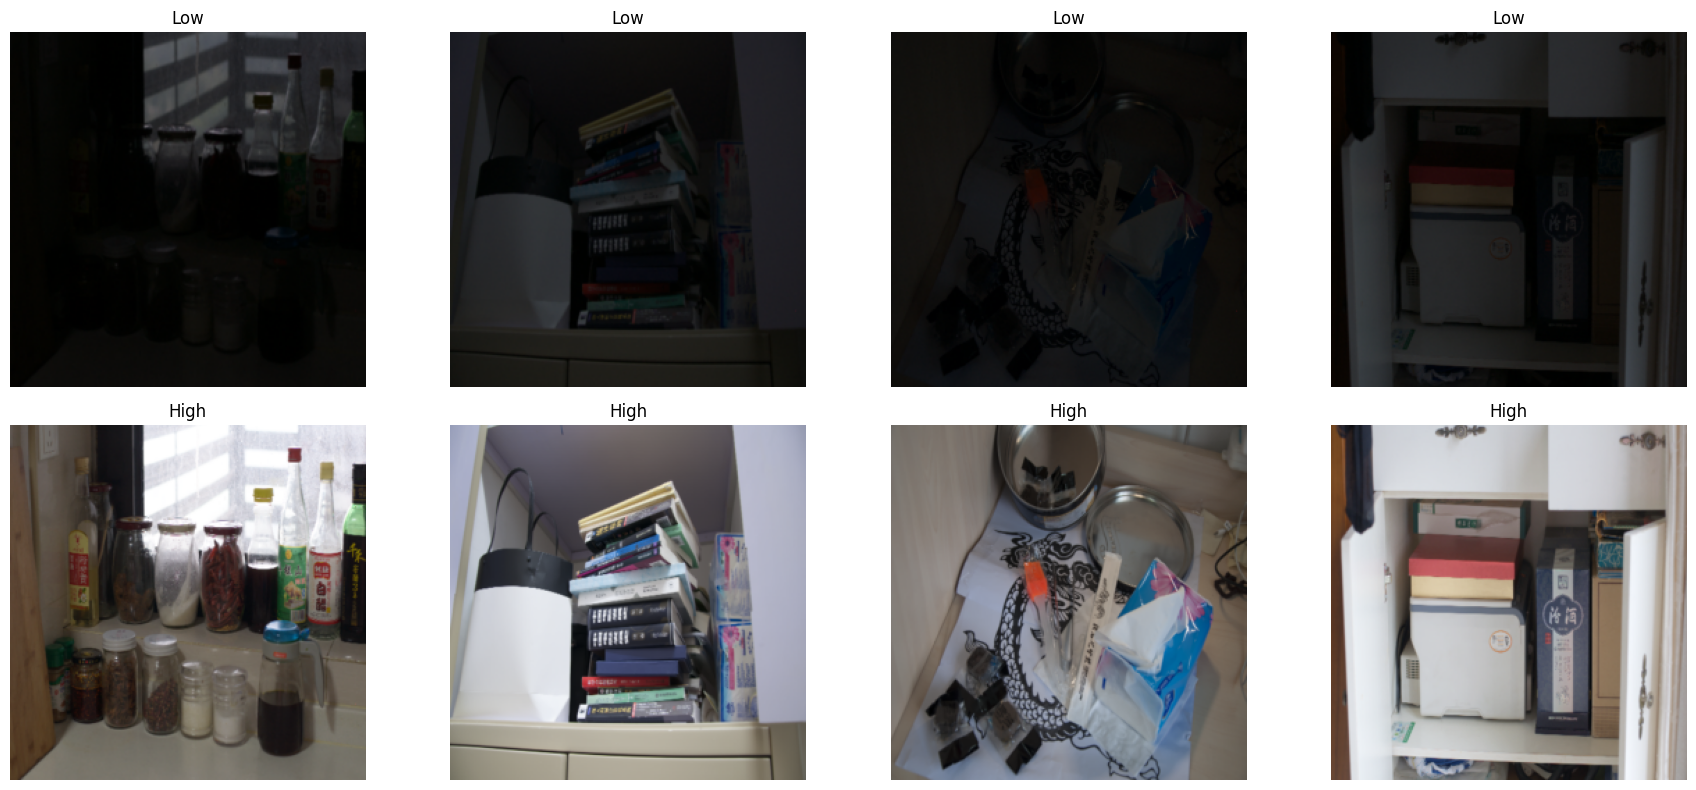

In [6]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

## Model Architecture

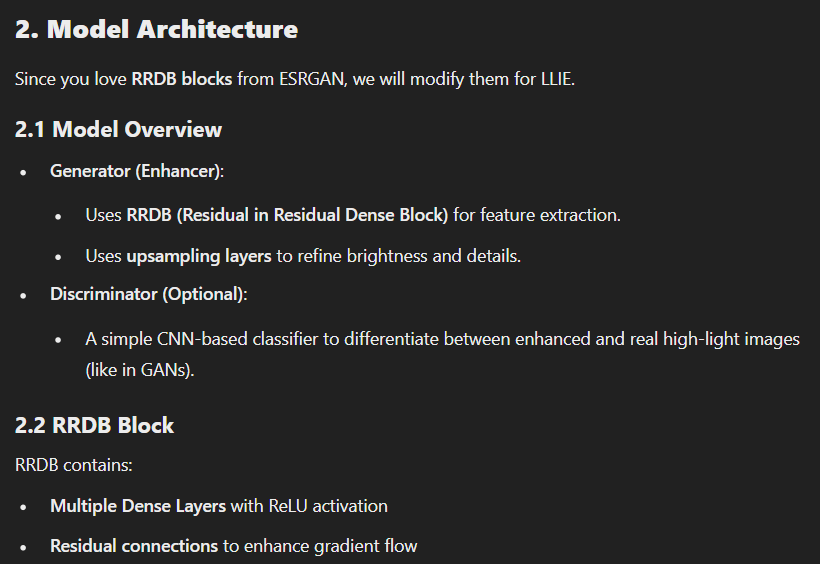

In [7]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [8]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [9]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [10]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)

In [11]:
## Common evaluating Metrics
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Initialize models and losses
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
opt_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated

In [12]:
def validate(generator, val_loader, epoch):
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0, 'val_loss': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Validation loss (L1 + perceptual)
            loss = (10 * F.l1_loss(fake, high) + 0.1 * criterion_perceptual(fake, high)).item()
            
            # Update metrics
            val_metrics['val_loss'] += loss
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    for k in val_metrics:
        val_metrics[k] /= len(val_loader)
    return val_metrics

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [13]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_CHECKPOINTS_gaussian_blur"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_psnr=0
    best_lpips=100

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)
            
            gp = compute_gradient_penalty(discriminator, high.data, fake.data)
            d_loss = (real_loss + fake_loss) / 2+ 10*gp
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 10
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [15]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:55<00:00,  1.12s/it, D_loss=45.510, G_loss=2.095,
                                                                                


Validation @ Epoch 1:
PSNR: 14.82 dB | SSIM: 0.6293 | LPIPS: 0.4478
🔥 New best model (PSNR: 14.8163 | LPIPS: 0.4478 | SSIM: 0.6293) saved!
🔥 New best model (LPIPS: 0.4478 | SSIM: 0.6293) saved!
🔥 New best model (PSNR: 14.8163 | SSIM: 0.6293) saved!
🔥 New best model (PSNR: 14.8163 | LPIPS: 0.4478) saved!
🔥 New best model (SSIM: 0.6293) saved!
🔥 New best model (PSNR: 14.8163) saved!
🔥 New best model (LPIPS: 0.4478) saved!


Epoch 2/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=55.023, G_loss=2.275,
                                                                                


Validation @ Epoch 2:
PSNR: 15.41 dB | SSIM: 0.6456 | LPIPS: 0.4232
🔥 New best model (PSNR: 15.4061 | LPIPS: 0.4232 | SSIM: 0.6456) saved!
🔥 New best model (LPIPS: 0.4232 | SSIM: 0.6456) saved!
🔥 New best model (PSNR: 15.4061 | SSIM: 0.6456) saved!
🔥 New best model (PSNR: 15.4061 | LPIPS: 0.4232) saved!
🔥 New best model (SSIM: 0.6456) saved!
🔥 New best model (PSNR: 15.4061) saved!
🔥 New best model (LPIPS: 0.4232) saved!


Epoch 3/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=18.924, G_loss=2.476,
                                                                                


Validation @ Epoch 3:
PSNR: 15.05 dB | SSIM: 0.6543 | LPIPS: 0.4006
🔥 New best model (LPIPS: 0.4006 | SSIM: 0.6543) saved!
🔥 New best model (SSIM: 0.6543) saved!
🔥 New best model (LPIPS: 0.4006) saved!


Epoch 4/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=13.107, G_loss=1.959,
                                                                                


Validation @ Epoch 4:
PSNR: 15.93 dB | SSIM: 0.7160 | LPIPS: 0.3592
🔥 New best model (PSNR: 15.9270 | LPIPS: 0.3592 | SSIM: 0.7160) saved!
🔥 New best model (LPIPS: 0.3592 | SSIM: 0.7160) saved!
🔥 New best model (PSNR: 15.9270 | SSIM: 0.7160) saved!
🔥 New best model (PSNR: 15.9270 | LPIPS: 0.3592) saved!
🔥 New best model (SSIM: 0.7160) saved!
🔥 New best model (PSNR: 15.9270) saved!
🔥 New best model (LPIPS: 0.3592) saved!


Epoch 5/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=2.034, G_loss=1.728, 
                                                                                


Validation @ Epoch 5:
PSNR: 15.74 dB | SSIM: 0.7251 | LPIPS: 0.3482
🔥 New best model (LPIPS: 0.3482 | SSIM: 0.7251) saved!
🔥 New best model (SSIM: 0.7251) saved!
🔥 New best model (LPIPS: 0.3482) saved!


Epoch 6/200: 100%|█| 49/49 [00:49<00:00,  1.02s/it, D_loss=4.544, G_loss=2.260, 
                                                                                


Validation @ Epoch 6:
PSNR: 16.18 dB | SSIM: 0.7464 | LPIPS: 0.3154
🔥 New best model (PSNR: 16.1831 | LPIPS: 0.3154 | SSIM: 0.7464) saved!
🔥 New best model (LPIPS: 0.3154 | SSIM: 0.7464) saved!
🔥 New best model (PSNR: 16.1831 | SSIM: 0.7464) saved!
🔥 New best model (PSNR: 16.1831 | LPIPS: 0.3154) saved!
🔥 New best model (SSIM: 0.7464) saved!
🔥 New best model (PSNR: 16.1831) saved!
🔥 New best model (LPIPS: 0.3154) saved!


Epoch 7/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=14.737, G_loss=2.761,
                                                                                


Validation @ Epoch 7:
PSNR: 15.35 dB | SSIM: 0.7299 | LPIPS: 0.3295


Epoch 8/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.097, G_loss=1.795, 
                                                                                


Validation @ Epoch 8:
PSNR: 16.63 dB | SSIM: 0.7577 | LPIPS: 0.3117
🔥 New best model (PSNR: 16.6304 | LPIPS: 0.3117 | SSIM: 0.7577) saved!
🔥 New best model (LPIPS: 0.3117 | SSIM: 0.7577) saved!
🔥 New best model (PSNR: 16.6304 | SSIM: 0.7577) saved!
🔥 New best model (PSNR: 16.6304 | LPIPS: 0.3117) saved!
🔥 New best model (SSIM: 0.7577) saved!
🔥 New best model (PSNR: 16.6304) saved!
🔥 New best model (LPIPS: 0.3117) saved!


Epoch 9/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.899, G_loss=1.786, 
                                                                                


Validation @ Epoch 9:
PSNR: 16.76 dB | SSIM: 0.7584 | LPIPS: 0.3025
🔥 New best model (PSNR: 16.7596 | LPIPS: 0.3025 | SSIM: 0.7584) saved!
🔥 New best model (LPIPS: 0.3025 | SSIM: 0.7584) saved!
🔥 New best model (PSNR: 16.7596 | SSIM: 0.7584) saved!
🔥 New best model (PSNR: 16.7596 | LPIPS: 0.3025) saved!
🔥 New best model (SSIM: 0.7584) saved!
🔥 New best model (PSNR: 16.7596) saved!
🔥 New best model (LPIPS: 0.3025) saved!


Epoch 10/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=2.501, G_loss=2.528,
                                                                                


Validation @ Epoch 10:
PSNR: 16.02 dB | SSIM: 0.7510 | LPIPS: 0.2984
🔥 New best model (LPIPS: 0.2984) saved!


Epoch 11/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.196, G_loss=1.910,
                                                                                


Validation @ Epoch 11:
PSNR: 16.56 dB | SSIM: 0.7710 | LPIPS: 0.2923
🔥 New best model (LPIPS: 0.2923 | SSIM: 0.7710) saved!
🔥 New best model (SSIM: 0.7710) saved!
🔥 New best model (LPIPS: 0.2923) saved!


Epoch 12/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.891, G_loss=2.008,
                                                                                


Validation @ Epoch 12:
PSNR: 16.61 dB | SSIM: 0.7715 | LPIPS: 0.2871
🔥 New best model (LPIPS: 0.2871 | SSIM: 0.7715) saved!
🔥 New best model (SSIM: 0.7715) saved!
🔥 New best model (LPIPS: 0.2871) saved!


Epoch 13/200: 100%|█| 49/49 [00:50<00:00,  1.04s/it, D_loss=1.171, G_loss=1.857,
                                                                                


Validation @ Epoch 13:
PSNR: 16.58 dB | SSIM: 0.7741 | LPIPS: 0.2912
🔥 New best model (SSIM: 0.7741) saved!


Epoch 14/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=1.901, G_loss=2.304,
                                                                                


Validation @ Epoch 14:
PSNR: 16.59 dB | SSIM: 0.7816 | LPIPS: 0.2806
🔥 New best model (LPIPS: 0.2806 | SSIM: 0.7816) saved!
🔥 New best model (SSIM: 0.7816) saved!
🔥 New best model (LPIPS: 0.2806) saved!


Epoch 15/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.091, G_loss=2.643,
                                                                                


Validation @ Epoch 15:
PSNR: 16.29 dB | SSIM: 0.7713 | LPIPS: 0.2786
🔥 New best model (LPIPS: 0.2786) saved!


Epoch 16/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.250, G_loss=1.540,
                                                                                


Validation @ Epoch 16:
PSNR: 16.70 dB | SSIM: 0.7881 | LPIPS: 0.2627
🔥 New best model (LPIPS: 0.2627 | SSIM: 0.7881) saved!
🔥 New best model (SSIM: 0.7881) saved!
🔥 New best model (LPIPS: 0.2627) saved!


Epoch 17/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.360, G_loss=2.346,
                                                                                


Validation @ Epoch 17:
PSNR: 16.57 dB | SSIM: 0.7855 | LPIPS: 0.2716


Epoch 18/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.978, G_loss=1.680,
                                                                                


Validation @ Epoch 18:
PSNR: 16.77 dB | SSIM: 0.7931 | LPIPS: 0.2591
🔥 New best model (PSNR: 16.7692 | LPIPS: 0.2591 | SSIM: 0.7931) saved!
🔥 New best model (LPIPS: 0.2591 | SSIM: 0.7931) saved!
🔥 New best model (PSNR: 16.7692 | SSIM: 0.7931) saved!
🔥 New best model (PSNR: 16.7692 | LPIPS: 0.2591) saved!
🔥 New best model (SSIM: 0.7931) saved!
🔥 New best model (PSNR: 16.7692) saved!
🔥 New best model (LPIPS: 0.2591) saved!


Epoch 19/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=1.075, G_loss=2.912,
                                                                                


Validation @ Epoch 19:
PSNR: 17.07 dB | SSIM: 0.7951 | LPIPS: 0.2587
🔥 New best model (PSNR: 17.0724 | LPIPS: 0.2587 | SSIM: 0.7951) saved!
🔥 New best model (LPIPS: 0.2587 | SSIM: 0.7951) saved!
🔥 New best model (PSNR: 17.0724 | SSIM: 0.7951) saved!
🔥 New best model (PSNR: 17.0724 | LPIPS: 0.2587) saved!
🔥 New best model (SSIM: 0.7951) saved!
🔥 New best model (PSNR: 17.0724) saved!
🔥 New best model (LPIPS: 0.2587) saved!


Epoch 20/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=3.087, G_loss=2.142,
                                                                                


Validation @ Epoch 20:
PSNR: 16.56 dB | SSIM: 0.7916 | LPIPS: 0.2686


Epoch 21/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=1.610, G_loss=2.243,
                                                                                


Validation @ Epoch 21:
PSNR: 16.35 dB | SSIM: 0.7714 | LPIPS: 0.2967


Epoch 22/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=2.233, G_loss=1.403,
                                                                                


Validation @ Epoch 22:
PSNR: 16.73 dB | SSIM: 0.8000 | LPIPS: 0.2563
🔥 New best model (LPIPS: 0.2563 | SSIM: 0.8000) saved!
🔥 New best model (SSIM: 0.8000) saved!
🔥 New best model (LPIPS: 0.2563) saved!


Epoch 23/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.085, G_loss=1.708,
                                                                                


Validation @ Epoch 23:
PSNR: 17.01 dB | SSIM: 0.7886 | LPIPS: 0.2616


Epoch 24/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.896, G_loss=2.283,
                                                                                


Validation @ Epoch 24:
PSNR: 16.96 dB | SSIM: 0.8060 | LPIPS: 0.2426
🔥 New best model (LPIPS: 0.2426 | SSIM: 0.8060) saved!
🔥 New best model (SSIM: 0.8060) saved!
🔥 New best model (LPIPS: 0.2426) saved!


Epoch 25/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=6.029, G_loss=2.216,
                                                                                


Validation @ Epoch 25:
PSNR: 16.34 dB | SSIM: 0.7942 | LPIPS: 0.2606


Epoch 26/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=2.121, G_loss=1.988,
                                                                                


Validation @ Epoch 26:
PSNR: 16.35 dB | SSIM: 0.7896 | LPIPS: 0.2524


Epoch 27/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.312, G_loss=2.335,
                                                                                


Validation @ Epoch 27:
PSNR: 16.48 dB | SSIM: 0.7965 | LPIPS: 0.2488


Epoch 28/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.595, G_loss=1.902,
                                                                                


Validation @ Epoch 28:
PSNR: 16.80 dB | SSIM: 0.8093 | LPIPS: 0.2432
🔥 New best model (SSIM: 0.8093) saved!


Epoch 29/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.427, G_loss=2.143,
                                                                                


Validation @ Epoch 29:
PSNR: 16.16 dB | SSIM: 0.7801 | LPIPS: 0.2778


Epoch 30/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.894, G_loss=1.811,
                                                                                


Validation @ Epoch 30:
PSNR: 16.93 dB | SSIM: 0.8119 | LPIPS: 0.2385
🔥 New best model (LPIPS: 0.2385 | SSIM: 0.8119) saved!
🔥 New best model (SSIM: 0.8119) saved!
🔥 New best model (LPIPS: 0.2385) saved!


Epoch 31/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=8.151, G_loss=2.096,
                                                                                


Validation @ Epoch 31:
PSNR: 16.66 dB | SSIM: 0.8020 | LPIPS: 0.2657


Epoch 32/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.626, G_loss=1.982,
                                                                                


Validation @ Epoch 32:
PSNR: 17.00 dB | SSIM: 0.8099 | LPIPS: 0.2473


Epoch 33/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=3.830, G_loss=2.087,
                                                                                


Validation @ Epoch 33:
PSNR: 16.73 dB | SSIM: 0.8056 | LPIPS: 0.2656


Epoch 34/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.925, G_loss=1.900,
                                                                                


Validation @ Epoch 34:
PSNR: 16.71 dB | SSIM: 0.8063 | LPIPS: 0.2449


Epoch 35/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.527, G_loss=2.224,
                                                                                


Validation @ Epoch 35:
PSNR: 16.85 dB | SSIM: 0.8081 | LPIPS: 0.2459


Epoch 36/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.918, G_loss=1.683,
                                                                                


Validation @ Epoch 36:
PSNR: 17.00 dB | SSIM: 0.8155 | LPIPS: 0.2446
🔥 New best model (SSIM: 0.8155) saved!


Epoch 37/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=1.021, G_loss=1.779,
                                                                                


Validation @ Epoch 37:
PSNR: 17.25 dB | SSIM: 0.8192 | LPIPS: 0.2500
🔥 New best model (PSNR: 17.2493 | SSIM: 0.8192) saved!
🔥 New best model (SSIM: 0.8192) saved!
🔥 New best model (PSNR: 17.2493) saved!


Epoch 38/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.982, G_loss=2.390,
                                                                                


Validation @ Epoch 38:
PSNR: 17.09 dB | SSIM: 0.8172 | LPIPS: 0.2303
🔥 New best model (LPIPS: 0.2303) saved!


Epoch 39/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.232, G_loss=1.680,
                                                                                


Validation @ Epoch 39:
PSNR: 16.81 dB | SSIM: 0.8180 | LPIPS: 0.2361


Epoch 40/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.261, G_loss=1.961,
                                                                                


Validation @ Epoch 40:
PSNR: 16.84 dB | SSIM: 0.7939 | LPIPS: 0.2432


Epoch 41/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.994, G_loss=2.032,
                                                                                


Validation @ Epoch 41:
PSNR: 16.89 dB | SSIM: 0.8121 | LPIPS: 0.2501


Epoch 42/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.467, G_loss=1.772,
                                                                                


Validation @ Epoch 42:
PSNR: 16.58 dB | SSIM: 0.8095 | LPIPS: 0.2305


Epoch 43/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.978, G_loss=1.530,
                                                                                


Validation @ Epoch 43:
PSNR: 17.26 dB | SSIM: 0.8195 | LPIPS: 0.2217
🔥 New best model (PSNR: 17.2605 | LPIPS: 0.2217 | SSIM: 0.8195) saved!
🔥 New best model (LPIPS: 0.2217 | SSIM: 0.8195) saved!
🔥 New best model (PSNR: 17.2605 | SSIM: 0.8195) saved!
🔥 New best model (PSNR: 17.2605 | LPIPS: 0.2217) saved!
🔥 New best model (SSIM: 0.8195) saved!
🔥 New best model (PSNR: 17.2605) saved!
🔥 New best model (LPIPS: 0.2217) saved!


Epoch 44/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.816, G_loss=1.970,
                                                                                


Validation @ Epoch 44:
PSNR: 17.25 dB | SSIM: 0.8248 | LPIPS: 0.2306
🔥 New best model (SSIM: 0.8248) saved!


Epoch 45/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.843, G_loss=1.699,
                                                                                


Validation @ Epoch 45:
PSNR: 16.91 dB | SSIM: 0.8201 | LPIPS: 0.2406


Epoch 46/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.868, G_loss=1.988,
                                                                                


Validation @ Epoch 46:
PSNR: 17.11 dB | SSIM: 0.8227 | LPIPS: 0.2429


Epoch 47/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.012, G_loss=2.158,
                                                                                


Validation @ Epoch 47:
PSNR: 17.22 dB | SSIM: 0.8217 | LPIPS: 0.2293


Epoch 48/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=1.409, G_loss=1.807,
                                                                                


Validation @ Epoch 48:
PSNR: 17.28 dB | SSIM: 0.8197 | LPIPS: 0.2368
🔥 New best model (PSNR: 17.2814) saved!


Epoch 49/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.929, G_loss=2.237,
                                                                                


Validation @ Epoch 49:
PSNR: 17.01 dB | SSIM: 0.8100 | LPIPS: 0.2572


Epoch 50/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.781, G_loss=2.520,
                                                                                


Validation @ Epoch 50:
PSNR: 14.66 dB | SSIM: 0.7642 | LPIPS: 0.2939


Epoch 51/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.744, G_loss=1.779,
                                                                                


Validation @ Epoch 51:
PSNR: 16.88 dB | SSIM: 0.8103 | LPIPS: 0.2334


Epoch 52/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.776, G_loss=1.970,
                                                                                


Validation @ Epoch 52:
PSNR: 17.29 dB | SSIM: 0.8219 | LPIPS: 0.2292
🔥 New best model (PSNR: 17.2904) saved!


Epoch 53/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.814, G_loss=1.382,
                                                                                


Validation @ Epoch 53:
PSNR: 16.98 dB | SSIM: 0.8223 | LPIPS: 0.2319


Epoch 54/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.851, G_loss=1.695,
                                                                                


Validation @ Epoch 54:
PSNR: 17.11 dB | SSIM: 0.8283 | LPIPS: 0.2576
🔥 New best model (SSIM: 0.8283) saved!


Epoch 55/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.793, G_loss=1.790,
                                                                                


Validation @ Epoch 55:
PSNR: 16.90 dB | SSIM: 0.8102 | LPIPS: 0.2623


Epoch 56/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.812, G_loss=1.828,
                                                                                


Validation @ Epoch 56:
PSNR: 17.46 dB | SSIM: 0.8309 | LPIPS: 0.2181
🔥 New best model (PSNR: 17.4631 | LPIPS: 0.2181 | SSIM: 0.8309) saved!
🔥 New best model (LPIPS: 0.2181 | SSIM: 0.8309) saved!
🔥 New best model (PSNR: 17.4631 | SSIM: 0.8309) saved!
🔥 New best model (PSNR: 17.4631 | LPIPS: 0.2181) saved!
🔥 New best model (SSIM: 0.8309) saved!
🔥 New best model (PSNR: 17.4631) saved!
🔥 New best model (LPIPS: 0.2181) saved!


Epoch 57/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.812, G_loss=1.708,
                                                                                


Validation @ Epoch 57:
PSNR: 17.06 dB | SSIM: 0.8216 | LPIPS: 0.2255


Epoch 58/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.270, G_loss=1.870,
                                                                                


Validation @ Epoch 58:
PSNR: 17.00 dB | SSIM: 0.8259 | LPIPS: 0.2319


Epoch 59/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.802, G_loss=1.791,
                                                                                


Validation @ Epoch 59:
PSNR: 17.68 dB | SSIM: 0.8317 | LPIPS: 0.2123
🔥 New best model (PSNR: 17.6798 | LPIPS: 0.2123 | SSIM: 0.8317) saved!
🔥 New best model (LPIPS: 0.2123 | SSIM: 0.8317) saved!
🔥 New best model (PSNR: 17.6798 | SSIM: 0.8317) saved!
🔥 New best model (PSNR: 17.6798 | LPIPS: 0.2123) saved!
🔥 New best model (SSIM: 0.8317) saved!
🔥 New best model (PSNR: 17.6798) saved!
🔥 New best model (LPIPS: 0.2123) saved!


Epoch 60/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.724, G_loss=2.238,
                                                                                


Validation @ Epoch 60:
PSNR: 16.58 dB | SSIM: 0.8189 | LPIPS: 0.2389


Epoch 61/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.791, G_loss=2.436,
                                                                                


Validation @ Epoch 61:
PSNR: 16.71 dB | SSIM: 0.8145 | LPIPS: 0.2425


Epoch 62/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.737, G_loss=1.718,
                                                                                


Validation @ Epoch 62:
PSNR: 17.42 dB | SSIM: 0.8352 | LPIPS: 0.2030
🔥 New best model (LPIPS: 0.2030 | SSIM: 0.8352) saved!
🔥 New best model (SSIM: 0.8352) saved!
🔥 New best model (LPIPS: 0.2030) saved!


Epoch 63/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.789, G_loss=1.576,
                                                                                


Validation @ Epoch 63:
PSNR: 17.48 dB | SSIM: 0.8370 | LPIPS: 0.2137
🔥 New best model (SSIM: 0.8370) saved!


Epoch 64/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.749, G_loss=1.996,
                                                                                


Validation @ Epoch 64:
PSNR: 17.07 dB | SSIM: 0.8236 | LPIPS: 0.2178


Epoch 65/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.733, G_loss=1.612,
                                                                                


Validation @ Epoch 65:
PSNR: 17.58 dB | SSIM: 0.8377 | LPIPS: 0.2068
🔥 New best model (SSIM: 0.8377) saved!


Epoch 66/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.976, G_loss=2.223,
                                                                                


Validation @ Epoch 66:
PSNR: 16.83 dB | SSIM: 0.8168 | LPIPS: 0.2328


Epoch 67/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.824, G_loss=1.667,
                                                                                


Validation @ Epoch 67:
PSNR: 17.86 dB | SSIM: 0.8382 | LPIPS: 0.2184
🔥 New best model (PSNR: 17.8627 | SSIM: 0.8382) saved!
🔥 New best model (SSIM: 0.8382) saved!
🔥 New best model (PSNR: 17.8627) saved!


Epoch 68/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.795, G_loss=1.588,
                                                                                


Validation @ Epoch 68:
PSNR: 17.48 dB | SSIM: 0.8360 | LPIPS: 0.2088


Epoch 69/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.784, G_loss=1.757,
                                                                                


Validation @ Epoch 69:
PSNR: 17.70 dB | SSIM: 0.8411 | LPIPS: 0.1945
🔥 New best model (LPIPS: 0.1945 | SSIM: 0.8411) saved!
🔥 New best model (SSIM: 0.8411) saved!
🔥 New best model (LPIPS: 0.1945) saved!


Epoch 70/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.748, G_loss=2.516,
                                                                                


Validation @ Epoch 70:
PSNR: 16.94 dB | SSIM: 0.8169 | LPIPS: 0.2490


Epoch 71/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.884, G_loss=1.785,
                                                                                


Validation @ Epoch 71:
PSNR: 16.50 dB | SSIM: 0.8153 | LPIPS: 0.2666


Epoch 72/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=2.734, G_loss=1.904,
                                                                                


Validation @ Epoch 72:
PSNR: 16.99 dB | SSIM: 0.8193 | LPIPS: 0.2512


Epoch 73/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.731, G_loss=1.437,
                                                                                


Validation @ Epoch 73:
PSNR: 17.50 dB | SSIM: 0.8297 | LPIPS: 0.2075


Epoch 74/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.720, G_loss=2.076,
                                                                                


Validation @ Epoch 74:
PSNR: 17.68 dB | SSIM: 0.8406 | LPIPS: 0.2043


Epoch 75/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.157, G_loss=1.335,
                                                                                


Validation @ Epoch 75:
PSNR: 17.75 dB | SSIM: 0.8371 | LPIPS: 0.2124


Epoch 76/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.717, G_loss=2.244,
                                                                                


Validation @ Epoch 76:
PSNR: 17.51 dB | SSIM: 0.8330 | LPIPS: 0.2181


Epoch 77/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.733, G_loss=1.632,
                                                                                


Validation @ Epoch 77:
PSNR: 17.84 dB | SSIM: 0.8376 | LPIPS: 0.2050


Epoch 78/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.746, G_loss=1.878,
                                                                                


Validation @ Epoch 78:
PSNR: 17.61 dB | SSIM: 0.8320 | LPIPS: 0.2216


Epoch 79/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.765, G_loss=1.861,
                                                                                


Validation @ Epoch 79:
PSNR: 16.71 dB | SSIM: 0.8237 | LPIPS: 0.2235


Epoch 80/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.806, G_loss=1.376,
                                                                                


Validation @ Epoch 80:
PSNR: 16.46 dB | SSIM: 0.8120 | LPIPS: 0.2335


Epoch 81/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.730, G_loss=1.354,
                                                                                


Validation @ Epoch 81:
PSNR: 17.54 dB | SSIM: 0.8364 | LPIPS: 0.2053


Epoch 82/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.704, G_loss=1.857,
                                                                                


Validation @ Epoch 82:
PSNR: 17.26 dB | SSIM: 0.8289 | LPIPS: 0.2193


Epoch 83/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.741, G_loss=1.920,
                                                                                


Validation @ Epoch 83:
PSNR: 17.77 dB | SSIM: 0.8406 | LPIPS: 0.2081


Epoch 84/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.748, G_loss=1.503,
                                                                                


Validation @ Epoch 84:
PSNR: 17.40 dB | SSIM: 0.8383 | LPIPS: 0.2062


Epoch 85/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.702, G_loss=1.909,
                                                                                


Validation @ Epoch 85:
PSNR: 17.87 dB | SSIM: 0.8489 | LPIPS: 0.1962
🔥 New best model (PSNR: 17.8750 | SSIM: 0.8489) saved!
🔥 New best model (SSIM: 0.8489) saved!
🔥 New best model (PSNR: 17.8750) saved!


Epoch 86/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.983,
                                                                                


Validation @ Epoch 86:
PSNR: 17.85 dB | SSIM: 0.8404 | LPIPS: 0.2015


Epoch 87/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.780, G_loss=1.753,
                                                                                


Validation @ Epoch 87:
PSNR: 17.05 dB | SSIM: 0.8308 | LPIPS: 0.2112


Epoch 88/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.744, G_loss=1.764,
                                                                                


Validation @ Epoch 88:
PSNR: 17.96 dB | SSIM: 0.8490 | LPIPS: 0.1965
🔥 New best model (PSNR: 17.9577 | SSIM: 0.8490) saved!
🔥 New best model (SSIM: 0.8490) saved!
🔥 New best model (PSNR: 17.9577) saved!


Epoch 89/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.722, G_loss=1.615,
                                                                                


Validation @ Epoch 89:
PSNR: 17.34 dB | SSIM: 0.8330 | LPIPS: 0.2201


Epoch 90/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.714, G_loss=1.689,
                                                                                


Validation @ Epoch 90:
PSNR: 17.92 dB | SSIM: 0.8462 | LPIPS: 0.2040


Epoch 91/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.117, G_loss=1.561,
                                                                                


Validation @ Epoch 91:
PSNR: 17.79 dB | SSIM: 0.8433 | LPIPS: 0.2099


Epoch 92/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.727, G_loss=2.231,
                                                                                


Validation @ Epoch 92:
PSNR: 17.30 dB | SSIM: 0.8302 | LPIPS: 0.2245


Epoch 93/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.938, G_loss=1.419,
                                                                                


Validation @ Epoch 93:
PSNR: 17.59 dB | SSIM: 0.8350 | LPIPS: 0.2116


Epoch 94/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.728, G_loss=1.800,
                                                                                


Validation @ Epoch 94:
PSNR: 17.73 dB | SSIM: 0.8389 | LPIPS: 0.2103


Epoch 95/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.705, G_loss=1.365,
                                                                                


Validation @ Epoch 95:
PSNR: 17.88 dB | SSIM: 0.8464 | LPIPS: 0.1965


Epoch 96/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.703, G_loss=1.629,
                                                                                


Validation @ Epoch 96:
PSNR: 18.04 dB | SSIM: 0.8454 | LPIPS: 0.2005
🔥 New best model (PSNR: 18.0413) saved!


Epoch 97/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.711, G_loss=1.576,
                                                                                


Validation @ Epoch 97:
PSNR: 17.75 dB | SSIM: 0.8473 | LPIPS: 0.2057


Epoch 98/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.719, G_loss=1.559,
                                                                                


Validation @ Epoch 98:
PSNR: 17.86 dB | SSIM: 0.8490 | LPIPS: 0.1957


Epoch 99/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.721, G_loss=1.668,
                                                                                


Validation @ Epoch 99:
PSNR: 18.11 dB | SSIM: 0.8503 | LPIPS: 0.2044
🔥 New best model (PSNR: 18.1089 | SSIM: 0.8503) saved!
🔥 New best model (SSIM: 0.8503) saved!
🔥 New best model (PSNR: 18.1089) saved!


Epoch 100/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.699, G_loss=2.302
                                                                                


Validation @ Epoch 100:
PSNR: 17.89 dB | SSIM: 0.8413 | LPIPS: 0.2003


Epoch 101/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.721, G_loss=2.022
                                                                                


Validation @ Epoch 101:
PSNR: 17.85 dB | SSIM: 0.8493 | LPIPS: 0.2019


Epoch 102/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.711, G_loss=1.710
                                                                                


Validation @ Epoch 102:
PSNR: 17.58 dB | SSIM: 0.8384 | LPIPS: 0.2028


Epoch 103/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.703, G_loss=1.282
                                                                                


Validation @ Epoch 103:
PSNR: 16.99 dB | SSIM: 0.8338 | LPIPS: 0.2267


Epoch 104/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.744, G_loss=1.316
                                                                                


Validation @ Epoch 104:
PSNR: 17.53 dB | SSIM: 0.8418 | LPIPS: 0.2070


Epoch 105/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.540, G_loss=1.361
                                                                                


Validation @ Epoch 105:
PSNR: 18.17 dB | SSIM: 0.8514 | LPIPS: 0.2077
🔥 New best model (PSNR: 18.1730 | SSIM: 0.8514) saved!
🔥 New best model (SSIM: 0.8514) saved!
🔥 New best model (PSNR: 18.1730) saved!


Epoch 106/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.779, G_loss=1.677
                                                                                


Validation @ Epoch 106:
PSNR: 17.60 dB | SSIM: 0.8401 | LPIPS: 0.2097


Epoch 107/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.741, G_loss=1.618
                                                                                


Validation @ Epoch 107:
PSNR: 17.79 dB | SSIM: 0.8450 | LPIPS: 0.2074


Epoch 108/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.848, G_loss=1.718
                                                                                


Validation @ Epoch 108:
PSNR: 17.48 dB | SSIM: 0.8414 | LPIPS: 0.2135


Epoch 109/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.856, G_loss=2.360
                                                                                


Validation @ Epoch 109:
PSNR: 17.17 dB | SSIM: 0.8279 | LPIPS: 0.2016


Epoch 110/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.715, G_loss=1.423
                                                                                


Validation @ Epoch 110:
PSNR: 18.09 dB | SSIM: 0.8482 | LPIPS: 0.2011


Epoch 111/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.776, G_loss=1.763
                                                                                


Validation @ Epoch 111:
PSNR: 17.77 dB | SSIM: 0.8400 | LPIPS: 0.2064


Epoch 112/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.778, G_loss=1.501
                                                                                


Validation @ Epoch 112:
PSNR: 18.14 dB | SSIM: 0.8494 | LPIPS: 0.2041


Epoch 113/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.806, G_loss=1.340
                                                                                


Validation @ Epoch 113:
PSNR: 17.88 dB | SSIM: 0.8508 | LPIPS: 0.1904
🔥 New best model (LPIPS: 0.1904) saved!


Epoch 114/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.726, G_loss=1.809
                                                                                


Validation @ Epoch 114:
PSNR: 16.57 dB | SSIM: 0.8339 | LPIPS: 0.2121


Epoch 115/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.706, G_loss=1.610
                                                                                


Validation @ Epoch 115:
PSNR: 18.00 dB | SSIM: 0.8445 | LPIPS: 0.2002


Epoch 116/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.720, G_loss=1.757
                                                                                


Validation @ Epoch 116:
PSNR: 18.13 dB | SSIM: 0.8517 | LPIPS: 0.2014
🔥 New best model (SSIM: 0.8517) saved!


Epoch 117/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.718, G_loss=1.859
                                                                                


Validation @ Epoch 117:
PSNR: 18.24 dB | SSIM: 0.8556 | LPIPS: 0.1891
🔥 New best model (PSNR: 18.2381 | LPIPS: 0.1891 | SSIM: 0.8556) saved!
🔥 New best model (LPIPS: 0.1891 | SSIM: 0.8556) saved!
🔥 New best model (PSNR: 18.2381 | SSIM: 0.8556) saved!
🔥 New best model (PSNR: 18.2381 | LPIPS: 0.1891) saved!
🔥 New best model (SSIM: 0.8556) saved!
🔥 New best model (PSNR: 18.2381) saved!
🔥 New best model (LPIPS: 0.1891) saved!


Epoch 118/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.807, G_loss=1.367
                                                                                


Validation @ Epoch 118:
PSNR: 18.00 dB | SSIM: 0.8486 | LPIPS: 0.2128


Epoch 119/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.720, G_loss=1.953
                                                                                


Validation @ Epoch 119:
PSNR: 17.33 dB | SSIM: 0.8285 | LPIPS: 0.2120


Epoch 120/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.707, G_loss=1.962
                                                                                


Validation @ Epoch 120:
PSNR: 17.63 dB | SSIM: 0.8416 | LPIPS: 0.2206


Epoch 121/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.705, G_loss=1.702
                                                                                


Validation @ Epoch 121:
PSNR: 17.93 dB | SSIM: 0.8448 | LPIPS: 0.1974


Epoch 122/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.708, G_loss=1.437
                                                                                


Validation @ Epoch 122:
PSNR: 17.77 dB | SSIM: 0.8395 | LPIPS: 0.2126


Epoch 123/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.746, G_loss=1.837
                                                                                


Validation @ Epoch 123:
PSNR: 16.32 dB | SSIM: 0.8159 | LPIPS: 0.2357


Epoch 124/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.706, G_loss=1.649
                                                                                


Validation @ Epoch 124:
PSNR: 17.94 dB | SSIM: 0.8450 | LPIPS: 0.2047


Epoch 125/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.704, G_loss=2.091
                                                                                


Validation @ Epoch 125:
PSNR: 18.16 dB | SSIM: 0.8485 | LPIPS: 0.2049


Epoch 126/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.708, G_loss=1.507
                                                                                


Validation @ Epoch 126:
PSNR: 17.98 dB | SSIM: 0.8455 | LPIPS: 0.2198


Epoch 127/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.715, G_loss=1.637
                                                                                


Validation @ Epoch 127:
PSNR: 17.86 dB | SSIM: 0.8481 | LPIPS: 0.1990


Epoch 128/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.718, G_loss=1.563
                                                                                


Validation @ Epoch 128:
PSNR: 17.81 dB | SSIM: 0.8458 | LPIPS: 0.1991


Epoch 129/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.727, G_loss=1.887
                                                                                


Validation @ Epoch 129:
PSNR: 17.79 dB | SSIM: 0.8485 | LPIPS: 0.2024


Epoch 130/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.704, G_loss=1.829
                                                                                


Validation @ Epoch 130:
PSNR: 17.93 dB | SSIM: 0.8454 | LPIPS: 0.2076


Epoch 131/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.711, G_loss=1.647
                                                                                


Validation @ Epoch 131:
PSNR: 18.01 dB | SSIM: 0.8504 | LPIPS: 0.1945


Epoch 132/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.708, G_loss=1.460
                                                                                


Validation @ Epoch 132:
PSNR: 17.77 dB | SSIM: 0.8454 | LPIPS: 0.1987


Epoch 133/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.712, G_loss=1.745
                                                                                


Validation @ Epoch 133:
PSNR: 18.09 dB | SSIM: 0.8480 | LPIPS: 0.2040


Epoch 134/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.709, G_loss=1.725
                                                                                


Validation @ Epoch 134:
PSNR: 18.21 dB | SSIM: 0.8550 | LPIPS: 0.1892


Epoch 135/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.709, G_loss=1.790
                                                                                


Validation @ Epoch 135:
PSNR: 18.47 dB | SSIM: 0.8556 | LPIPS: 0.1966
🔥 New best model (PSNR: 18.4726) saved!


Epoch 136/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.711, G_loss=1.676
                                                                                


Validation @ Epoch 136:
PSNR: 18.21 dB | SSIM: 0.8510 | LPIPS: 0.1970


Epoch 137/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.698, G_loss=1.613
                                                                                


Validation @ Epoch 137:
PSNR: 18.28 dB | SSIM: 0.8515 | LPIPS: 0.1927


Epoch 138/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.699, G_loss=2.055
                                                                                


Validation @ Epoch 138:
PSNR: 17.34 dB | SSIM: 0.8335 | LPIPS: 0.2125


Epoch 139/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.698, G_loss=1.838
                                                                                


Validation @ Epoch 139:
PSNR: 18.03 dB | SSIM: 0.8471 | LPIPS: 0.1984


Epoch 140/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.658
                                                                                


Validation @ Epoch 140:
PSNR: 18.06 dB | SSIM: 0.8506 | LPIPS: 0.2129


Epoch 141/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.914, G_loss=1.694
                                                                                


Validation @ Epoch 141:
PSNR: 18.03 dB | SSIM: 0.8467 | LPIPS: 0.1966


Epoch 142/200: 100%|█| 49/49 [00:51<00:00,  1.04s/it, D_loss=0.702, G_loss=1.665
                                                                                


Validation @ Epoch 142:
PSNR: 18.31 dB | SSIM: 0.8539 | LPIPS: 0.1957


Epoch 143/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.709, G_loss=1.363
                                                                                


Validation @ Epoch 143:
PSNR: 18.11 dB | SSIM: 0.8526 | LPIPS: 0.1969


Epoch 144/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.338
                                                                                


Validation @ Epoch 144:
PSNR: 18.43 dB | SSIM: 0.8506 | LPIPS: 0.1966


Epoch 145/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.695, G_loss=1.549
                                                                                


Validation @ Epoch 145:
PSNR: 18.23 dB | SSIM: 0.8505 | LPIPS: 0.2013


Epoch 146/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.701, G_loss=1.497
                                                                                


Validation @ Epoch 146:
PSNR: 17.59 dB | SSIM: 0.8422 | LPIPS: 0.2108


Epoch 147/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.702, G_loss=1.757
                                                                                


Validation @ Epoch 147:
PSNR: 17.21 dB | SSIM: 0.8424 | LPIPS: 0.2016


Epoch 148/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.707, G_loss=1.414
                                                                                


Validation @ Epoch 148:
PSNR: 17.93 dB | SSIM: 0.8463 | LPIPS: 0.2017


Epoch 149/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.697, G_loss=1.437
                                                                                


Validation @ Epoch 149:
PSNR: 18.30 dB | SSIM: 0.8549 | LPIPS: 0.1916


Epoch 150/200: 100%|█| 49/49 [00:52<00:00,  1.07s/it, D_loss=0.702, G_loss=1.670
                                                                                


Validation @ Epoch 150:
PSNR: 17.77 dB | SSIM: 0.8486 | LPIPS: 0.1907


Epoch 151/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.695, G_loss=1.522
                                                                                


Validation @ Epoch 151:
PSNR: 18.36 dB | SSIM: 0.8530 | LPIPS: 0.1925


Epoch 152/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.697, G_loss=2.515
                                                                                


Validation @ Epoch 152:
PSNR: 17.76 dB | SSIM: 0.8435 | LPIPS: 0.2148


Epoch 153/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.407
                                                                                


Validation @ Epoch 153:
PSNR: 18.00 dB | SSIM: 0.8475 | LPIPS: 0.1970


Epoch 154/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.760, G_loss=1.777
                                                                                


Validation @ Epoch 154:
PSNR: 17.90 dB | SSIM: 0.8428 | LPIPS: 0.2096


Epoch 155/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.696, G_loss=1.532
                                                                                


Validation @ Epoch 155:
PSNR: 18.16 dB | SSIM: 0.8506 | LPIPS: 0.2062


Epoch 156/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.697, G_loss=1.618
                                                                                


Validation @ Epoch 156:
PSNR: 18.37 dB | SSIM: 0.8582 | LPIPS: 0.1917
🔥 New best model (SSIM: 0.8582) saved!


Epoch 157/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.500
                                                                                


Validation @ Epoch 157:
PSNR: 18.47 dB | SSIM: 0.8547 | LPIPS: 0.1965
🔥 New best model (PSNR: 18.4735) saved!


Epoch 158/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.700, G_loss=1.615
                                                                                


Validation @ Epoch 158:
PSNR: 17.83 dB | SSIM: 0.8468 | LPIPS: 0.2027


Epoch 159/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.698, G_loss=1.337
                                                                                


Validation @ Epoch 159:
PSNR: 18.56 dB | SSIM: 0.8541 | LPIPS: 0.1912
🔥 New best model (PSNR: 18.5589) saved!


Epoch 160/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.699, G_loss=1.408
                                                                                


Validation @ Epoch 160:
PSNR: 18.33 dB | SSIM: 0.8524 | LPIPS: 0.2020


Epoch 161/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.704, G_loss=1.618
                                                                                


Validation @ Epoch 161:
PSNR: 17.67 dB | SSIM: 0.8421 | LPIPS: 0.2087


Epoch 162/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.710, G_loss=1.332
                                                                                


Validation @ Epoch 162:
PSNR: 18.09 dB | SSIM: 0.8495 | LPIPS: 0.1996


Epoch 163/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.719, G_loss=1.176
                                                                                


Validation @ Epoch 163:
PSNR: 18.08 dB | SSIM: 0.8469 | LPIPS: 0.2085


Epoch 164/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.341
                                                                                


Validation @ Epoch 164:
PSNR: 18.40 dB | SSIM: 0.8486 | LPIPS: 0.1988


Epoch 165/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.701, G_loss=1.523
                                                                                


Validation @ Epoch 165:
PSNR: 17.99 dB | SSIM: 0.8461 | LPIPS: 0.1980


Epoch 166/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.702, G_loss=1.481
                                                                                


Validation @ Epoch 166:
PSNR: 18.01 dB | SSIM: 0.8470 | LPIPS: 0.1999


Epoch 167/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.752, G_loss=1.368
                                                                                


Validation @ Epoch 167:
PSNR: 18.05 dB | SSIM: 0.8493 | LPIPS: 0.1958


Epoch 168/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.213, G_loss=1.630
                                                                                


Validation @ Epoch 168:
PSNR: 18.01 dB | SSIM: 0.8463 | LPIPS: 0.2013


Epoch 169/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=0.703, G_loss=1.525
                                                                                


Validation @ Epoch 169:
PSNR: 17.73 dB | SSIM: 0.8374 | LPIPS: 0.2083


Epoch 170/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.700, G_loss=1.434
                                                                                


Validation @ Epoch 170:
PSNR: 17.78 dB | SSIM: 0.8447 | LPIPS: 0.2085


Epoch 171/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.695, G_loss=1.564
                                                                                


Validation @ Epoch 171:
PSNR: 18.29 dB | SSIM: 0.8564 | LPIPS: 0.1940


Epoch 172/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.697, G_loss=1.555
                                                                                


Validation @ Epoch 172:
PSNR: 18.34 dB | SSIM: 0.8506 | LPIPS: 0.1958


Epoch 173/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.703, G_loss=1.651
                                                                                


Validation @ Epoch 173:
PSNR: 17.41 dB | SSIM: 0.8340 | LPIPS: 0.2202


Epoch 174/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.206, G_loss=1.496
                                                                                


Validation @ Epoch 174:
PSNR: 17.63 dB | SSIM: 0.8408 | LPIPS: 0.2067


Epoch 175/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.225, G_loss=1.347
                                                                                


Validation @ Epoch 175:
PSNR: 17.96 dB | SSIM: 0.8471 | LPIPS: 0.2012


Epoch 176/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.906, G_loss=1.733
                                                                                


Validation @ Epoch 176:
PSNR: 18.16 dB | SSIM: 0.8515 | LPIPS: 0.2018


Epoch 177/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=2.418, G_loss=1.443
                                                                                


Validation @ Epoch 177:
PSNR: 18.57 dB | SSIM: 0.8563 | LPIPS: 0.1931
🔥 New best model (PSNR: 18.5732) saved!


Epoch 178/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.074, G_loss=1.497
                                                                                


Validation @ Epoch 178:
PSNR: 18.03 dB | SSIM: 0.8486 | LPIPS: 0.2017


Epoch 179/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.229, G_loss=1.520
                                                                                


Validation @ Epoch 179:
PSNR: 18.23 dB | SSIM: 0.8503 | LPIPS: 0.2028


Epoch 180/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.084, G_loss=1.952
                                                                                


Validation @ Epoch 180:
PSNR: 18.20 dB | SSIM: 0.8517 | LPIPS: 0.2185


Epoch 181/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.503, G_loss=1.549
                                                                                


Validation @ Epoch 181:
PSNR: 18.28 dB | SSIM: 0.8556 | LPIPS: 0.1968


Epoch 182/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.192, G_loss=1.479
                                                                                


Validation @ Epoch 182:
PSNR: 18.38 dB | SSIM: 0.8521 | LPIPS: 0.2013


Epoch 183/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.227, G_loss=1.723
                                                                                


Validation @ Epoch 183:
PSNR: 18.45 dB | SSIM: 0.8522 | LPIPS: 0.2018


Epoch 184/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=2.124, G_loss=1.441
                                                                                


Validation @ Epoch 184:
PSNR: 18.37 dB | SSIM: 0.8548 | LPIPS: 0.1993


Epoch 185/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.318, G_loss=1.252
                                                                                


Validation @ Epoch 185:
PSNR: 18.03 dB | SSIM: 0.8512 | LPIPS: 0.2043


Epoch 186/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.373, G_loss=1.406
                                                                                


Validation @ Epoch 186:
PSNR: 18.16 dB | SSIM: 0.8481 | LPIPS: 0.2033


Epoch 187/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.342, G_loss=1.845
                                                                                


Validation @ Epoch 187:
PSNR: 18.07 dB | SSIM: 0.8445 | LPIPS: 0.2039


Epoch 188/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.236, G_loss=1.430
                                                                                


Validation @ Epoch 188:
PSNR: 17.76 dB | SSIM: 0.8423 | LPIPS: 0.1981


Epoch 189/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.009, G_loss=1.463
                                                                                


Validation @ Epoch 189:
PSNR: 18.14 dB | SSIM: 0.8569 | LPIPS: 0.1955


Epoch 190/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.260, G_loss=1.309
                                                                                


Validation @ Epoch 190:
PSNR: 18.02 dB | SSIM: 0.8426 | LPIPS: 0.2118


Epoch 191/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.911, G_loss=1.746
                                                                                


Validation @ Epoch 191:
PSNR: 18.26 dB | SSIM: 0.8479 | LPIPS: 0.2023


Epoch 192/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=1.344, G_loss=1.426
                                                                                


Validation @ Epoch 192:
PSNR: 18.42 dB | SSIM: 0.8550 | LPIPS: 0.2013


Epoch 193/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=2.177, G_loss=1.406
                                                                                


Validation @ Epoch 193:
PSNR: 18.22 dB | SSIM: 0.8525 | LPIPS: 0.2059


Epoch 194/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.109, G_loss=1.429
                                                                                


Validation @ Epoch 194:
PSNR: 18.41 dB | SSIM: 0.8520 | LPIPS: 0.1998


Epoch 195/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.257, G_loss=1.527
                                                                                


Validation @ Epoch 195:
PSNR: 18.36 dB | SSIM: 0.8458 | LPIPS: 0.2089


Epoch 196/200: 100%|█| 49/49 [00:51<00:00,  1.06s/it, D_loss=2.079, G_loss=1.354
                                                                                


Validation @ Epoch 196:
PSNR: 18.05 dB | SSIM: 0.8409 | LPIPS: 0.2069


Epoch 197/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=1.079, G_loss=1.440
                                                                                


Validation @ Epoch 197:
PSNR: 18.69 dB | SSIM: 0.8569 | LPIPS: 0.1959
🔥 New best model (PSNR: 18.6883) saved!


Epoch 198/200: 100%|█| 49/49 [00:52<00:00,  1.06s/it, D_loss=0.864, G_loss=1.421
                                                                                


Validation @ Epoch 198:
PSNR: 17.92 dB | SSIM: 0.8467 | LPIPS: 0.2142


Epoch 199/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=1.448, G_loss=1.631
                                                                                


Validation @ Epoch 199:
PSNR: 18.05 dB | SSIM: 0.8483 | LPIPS: 0.1954


Epoch 200/200: 100%|█| 49/49 [00:51<00:00,  1.05s/it, D_loss=0.995, G_loss=1.578
                                                                                


Validation @ Epoch 200:
PSNR: 18.09 dB | SSIM: 0.8475 | LPIPS: 0.2144


## Testing Code

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [17]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [18]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


{'psnr': tensor(19.0821, device='cuda:4'),
 'ssim': tensor(0.8263, device='cuda:4'),
 'lpips': tensor(0.2018, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_11.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples/sample_12.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_sam

In [19]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


{'psnr': tensor(19.0821, device='cuda:4'),
 'ssim': tensor(0.8263, device='cuda:4'),
 'lpips': tensor(0.2018, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/s

In [20]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


{'psnr': tensor(19.0821, device='cuda:4'),
 'ssim': tensor(0.8263, device='cuda:4'),
 'lpips': tensor(0.2018, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_

In [21]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


{'psnr': tensor(19.0821, device='cuda:4'),
 'ssim': tensor(0.8263, device='cuda:4'),
 'lpips': tensor(0.2018, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_

In [22]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


{'psnr': tensor(19.8205, device='cuda:4'),
 'ssim': tensor(0.8304, device='cuda:4'),
 'lpips': tensor(0.2041, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_11.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_sample

In [23]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


{'psnr': tensor(19.0777, device='cuda:4'),
 'ssim': tensor(0.8262, device='cuda:4'),
 'lpips': tensor(0.2046, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_11.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_sample

In [24]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_gaussian_blur/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


{'psnr': tensor(19.0821, device='cuda:4'),
 'ssim': tensor(0.8263, device='cuda:4'),
 'lpips': tensor(0.2018, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_11.png',
  'RRDB_CHECKPOINTS_gaussian_blur

In [25]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_CHECKPOINTS_gaussian_blur/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


{'psnr': tensor(19.0653, device='cuda:4'),
 'ssim': tensor(0.8254, device='cuda:4'),
 'lpips': tensor(0.2153, device='cuda:4'),
 'samples': ['RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_00.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_01.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_02.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_03.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_04.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_05.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_06.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_07.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_08.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_09.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_10.png',
  'RRDB_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_11.png

In [26]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_CHECKPOINTS_gaussian_blur"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

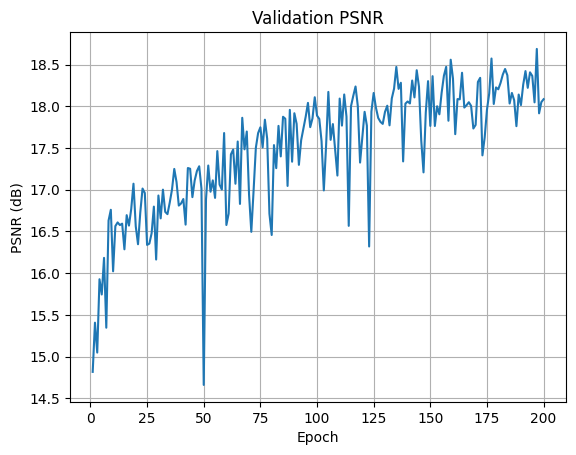

In [27]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_gaussian_blur/validation_psnr.png', dpi=300, bbox_inches='tight')

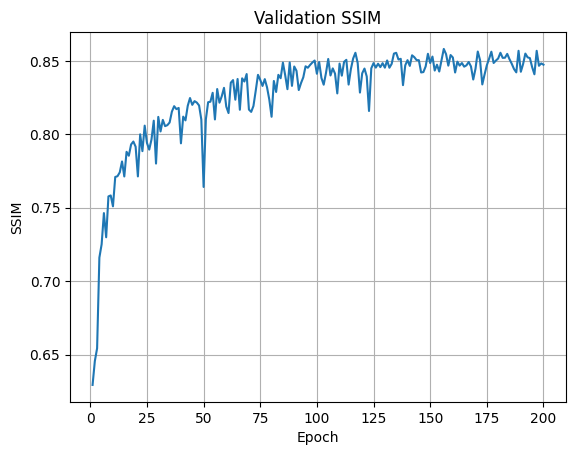

In [28]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_gaussian_blur/validation_ssim.png', dpi=300, bbox_inches='tight')

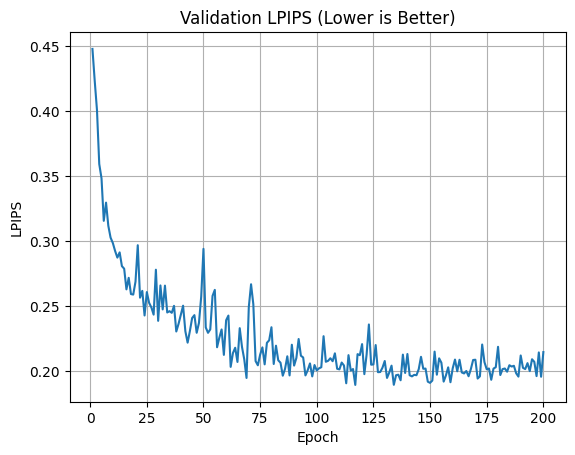

In [29]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_gaussian_blur/validation_lpips.png', dpi=300, bbox_inches='tight')

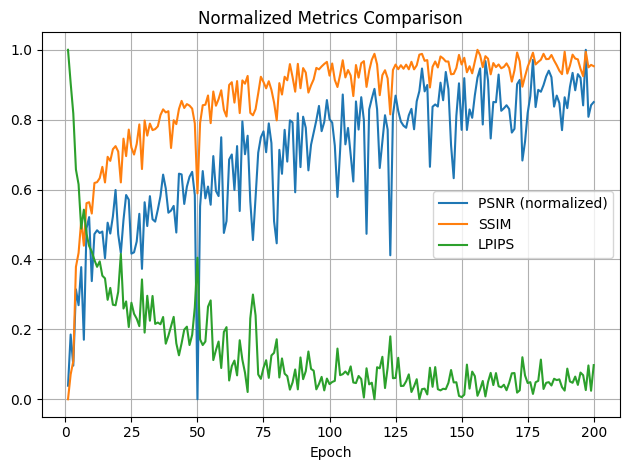

In [30]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend(loc='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_CHECKPOINTS_gaussian_blur/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()